# Détectez des faux billets
## Table of contents

1. [Preliminary](#Preliminary)
    1. [Context](#Context)
    2. [Requirements](#Requirements)
    3. [Graphics and options](#Graphics)
    4. [Data](#Data)   
2. [First Tour](#First)
    1. [Display](#Display)
    2. [Structure](#Structure)
    3. [Nan&Duplicated](#Nan)
    4. [Data inspection](#inspection)
    5. [Nan&Duplicated](#Nan)
    6. [Correlation Between variables](#Correlation)
3. [Cleaning](#Cleaning)
    1. [Replace boolean with 0 and 1](#Replace)
    2. [Split into 2 data, with and without NaN](#Split)
4. [Simple linear regression](#Simple)
    1. [With length](#length)
    2. [Visualisation linear regression](#Visualisation)
    3. [Model residues](#Model)
5. [Multiple linear regression](#MLR)
    1. [Model selection](#Model)
    2. [Test residual normality](#normality)
    3. [Leverage calculation](#Leverage)
    4. [Studentized residual](#Studentized)
    5. [Cook's distance](#Cook)
    6. [Atypical observations](#Atypical)
    7. [Model validation](#validation) 
6. [Prediction missing values](#Prediction)
    1. [New dataframe without Nan value](#New)
    2. [Export CSV](#Export)
    3. [New inspection without Nan](#new_inspection)    
7. [K-means](#K_means)
    1. [Data preparation](#scaler)
    2. [PCA](#PCA)
    3. [Scree plot](#Scree)
    4. [Correlation circle](#circle)
    5. [Projection of individuals on the factorial plane](#Projection)
    6. [Samples selection](#Samples)
    7. [Implementation and prediction](#Implementation)
    8. [Centroid Calculation](#Centroid)
    9. [Confusion Matrix](#Matrix_K)
8. [Logistic regression (supervised classification)](#Logistic)
    1. [Data preparation](#data_lr)
    2. [Model building](#building)
    3. [ROC curve](#ROC)
    4. [Confusion Matrix](#Matrix_lr)
    5. [Comparison of the 2 models: K-means & Logistic Regression](#Comparison)   
9. [Creation of prediction algorithm](#algorithm)
    1. [Testing the algorithm with billets_production](#billets_production)

## Preliminary <a name="Preliminary"></a>

### Context: <a name="Context"></a>

Projet10: Détectez des faux billets avec R ou Python <br/> 

Date Juin 2023 <br/>Auteur : Ai GE <br/>


Context du projet: L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM,
est une organisation publique ayant pour objectif de mettre en place des
méthodes d’identification des contrefaçons des billets en euros. Dans le
cadre de cette lutte, nous souhaitons mettre en place un algorithme qui
soit capable de différencier automatiquement les vrais des faux billets.<br/>


Objectifs:
Lorsqu’un billet arrive, nous avons une machine qui consigne l’ensemble
de ses caractéristiques géométriques. Au travers de nos années de lutte,
nous avons observé des différences de dimensions entre les vrais et les
faux billets. Ces différences sont difficilement notables à l’œil nu, mais une
machine devrait sans problème arriver à les différencier.
Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques
géométriques d’un billet, serait capable de définir si ce dernier est un vrai
ou un faux billet.

## Requirements: <a name="Requirements"></a>
* pandas
* numpy
* scikit-learn
* matplotlib

In [2]:
package_list=["padas", "numpy", "matplotlib", "scikit-learn"]

In [3]:
!python3 -V

Python 3.9.6


In [4]:
txt = !python3 -m pip freeze
check = lambda i : any ([(pack in i) for pack in package_list])
txt= [ i for i in txt if check (i)]
txt

['matplotlib==3.7.1',
 'matplotlib-inline==0.1.6',
 'numpy==1.24.3',
 'scikit-learn==1.2.2']

## Imports <a name="Imports"></a>

In [1]:
# builtin
import os
from pathlib import Path

# data
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import Series, DataFrame

# visualisation
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# statistic
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import shapiro
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from scipy import stats


# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools


# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


# PCA
from sklearn.decomposition import PCA

# cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import decomposition, preprocessing,cluster

## Graphics and options <a name="Graphics"></a>

In [3]:
# warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings(action = 'once')

## Data <a name="Data"></a>

In [4]:
os.listdir()

['.DS_Store',
 'billets_production.csv',
 '.ipynb_checkpoints',
 'Détectez des faux billets avec Python.ipynb',
 'data']

In [5]:
os.listdir("data/source/")

['.DS_Store', 'billets.csv']

In [6]:
path     = "./data/source/"
filename = "billets.csv"

In [7]:
df=pd.read_csv(path + filename,delimiter=";")
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# First Tour <a name="First"></a>

## Display <a name="Display"></a>

In [8]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [9]:
df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


In [10]:
df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
45,True,171.42,104.65,103.63,3.99,3.05,113.08
650,True,172.32,104.16,104.14,3.78,3.25,113.38
534,True,171.76,104.04,103.88,4.18,3.21,113.15
315,True,171.99,103.60,103.43,4.57,2.96,113.09
886,True,172.00,104.35,103.29,3.73,3.11,113.18


In [11]:
df.shape

(1500, 7)

Dimensions géométriques:
Nous disposons actuellement de six informations géométriques sur un
billet :
- length : la longueur du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;
- diagonal : la diagonale du billet (en mm).
Ces informations sont celles avec lesquelles l’algorithme devra opérer.

## Structure <a name="Structure"></a>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [13]:
df.dtypes.value_counts()

float64    6
bool       1
Name: count, dtype: int64

In [14]:
df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

## Nan & Duplicated <a name="Nan"></a>

In [15]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

37 valeurs null pour variable "margin_low "

In [16]:
df.duplicated().sum()

0

In [17]:
df.drop(columns="is_genuine").duplicated().sum()

0

## Data inspection <a name="inspection"></a>

In [18]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


std est plus important pour margin_low et length

In [19]:
df.iloc[:,0].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

In [20]:
df.iloc[:,0].value_counts(normalize=True).round(2)

is_genuine
True     0.67
False    0.33
Name: proportion, dtype: float64

<Axes: ylabel='count'>

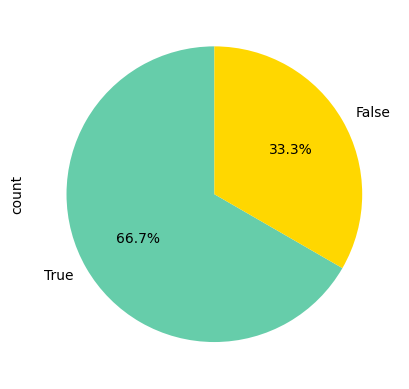

In [21]:
df.iloc[:,0].value_counts().plot(kind="pie",startangle=90, autopct='%1.1f%%', colors = ['#66cdaa', '#ffd700'] )

<Axes: xlabel='is_genuine', ylabel='margin_up'>

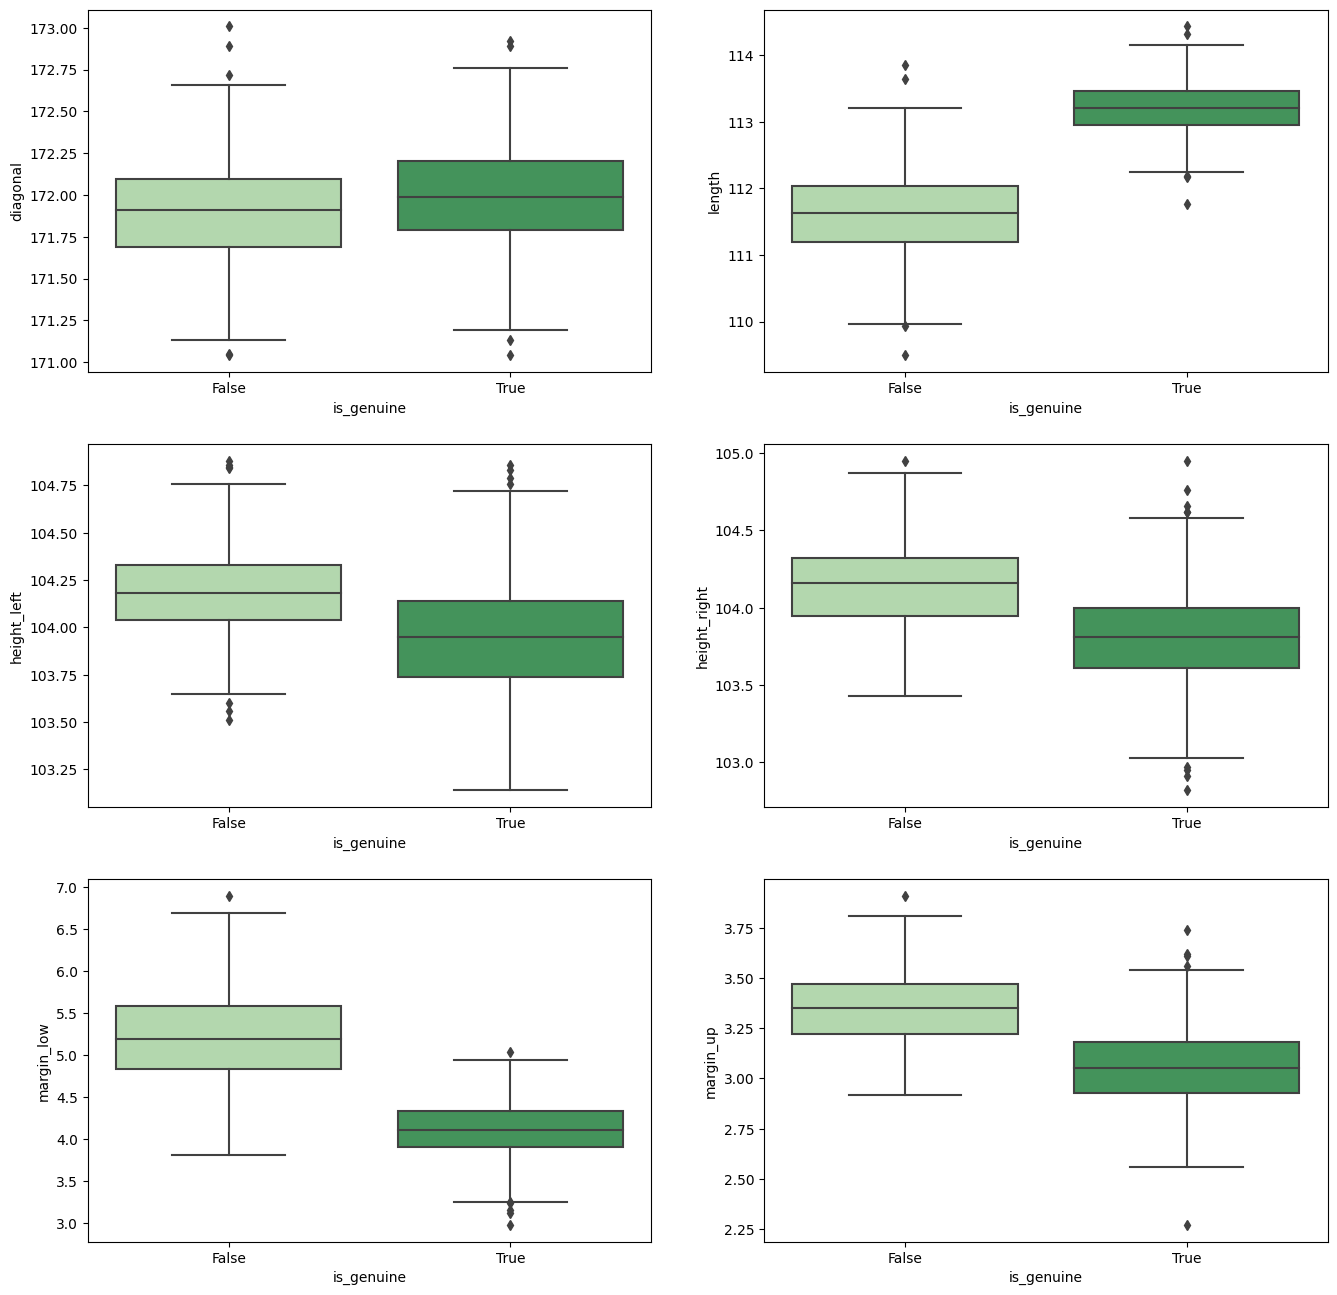

In [22]:
fig, axes= plt.subplots(3,2, figsize=(16,16))
sns.boxplot(y="diagonal", x="is_genuine", data=df, ax=axes[0,0],palette="Greens")
sns.boxplot(y="length", x="is_genuine", data=df, ax=axes[0,1],palette="Greens")
sns.boxplot(y="height_left", x="is_genuine", data=df, ax=axes[1,0],palette="Greens")
sns.boxplot(y="height_right", x="is_genuine", data=df, ax=axes[1,1],palette="Greens")
sns.boxplot(y="margin_low", x="is_genuine", data=df, ax=axes[2,0],palette="Greens")
sns.boxplot(y="margin_up", x="is_genuine", data=df, ax=axes[2,1],palette="Greens")

## Correlation Between variables <a name="Correlation"></a>

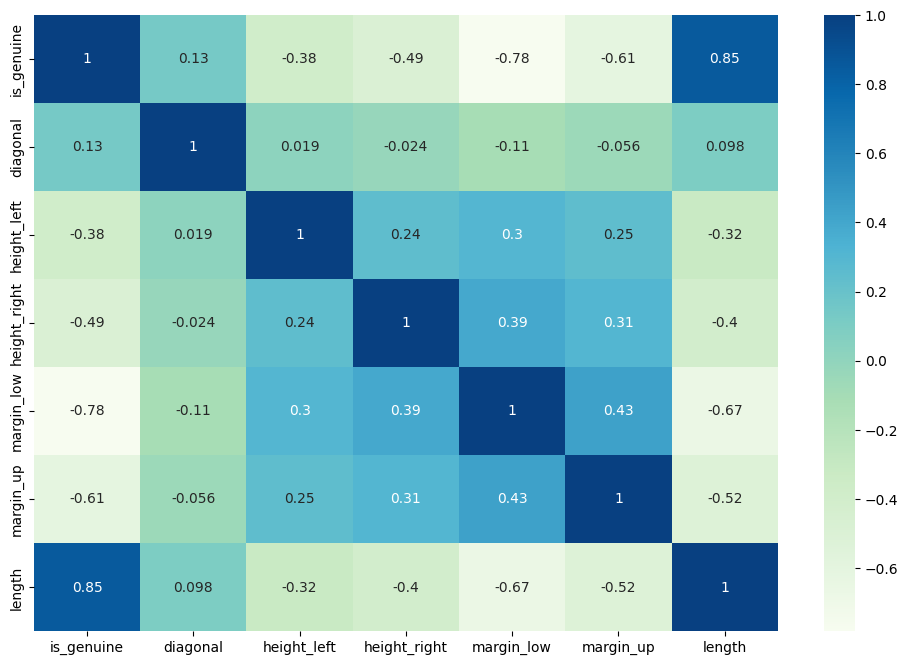

In [23]:
plt.figure(figsize = (12,8))
sns.heatmap(df[['is_genuine','diagonal', 'height_left', 'height_right',
                'margin_low','margin_up', 'length']].corr(),annot=True, cmap="GnBu")
plt.show()

length et margin_up les 2 variables sur lesquelles les correlations margin_low sont les plus marquées.

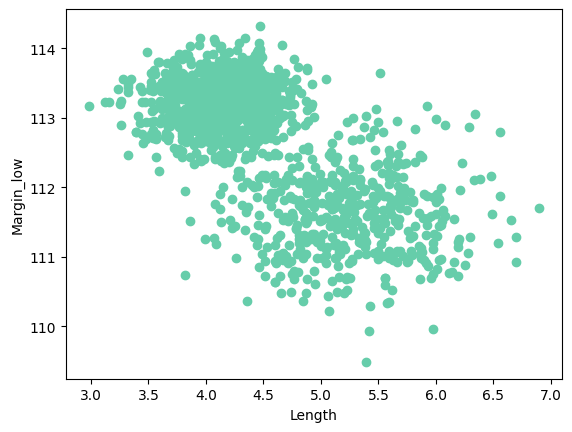

In [24]:
# Visualisation de la relation entre margin_low & length
plt.scatter(df.margin_low,df.length, c="#66cdaa")
plt.xlabel('Length') 
plt.ylabel('Margin_low')
plt.show()

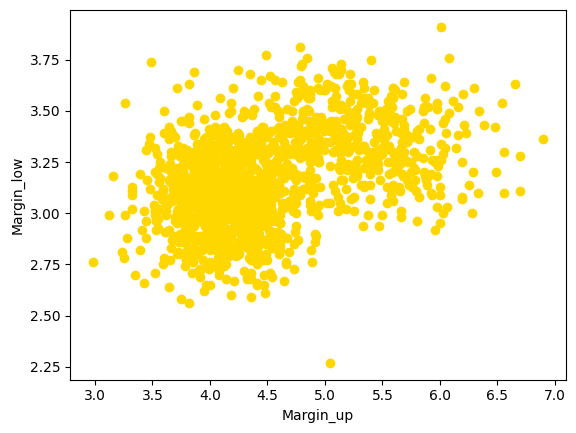

In [25]:
# Visualisation de la relation entre margin_low & margin_up
plt.scatter(df.margin_low,df.margin_up, c="#ffd700")
plt.xlabel('Margin_up') 
plt.ylabel('Margin_low')
plt.show()

margin_low & length a une ligne plus droite, faire une regression linéaire simple avec "length"

# Cleaning <a name="Cleaning"></a>

## Replace boolean with 0 and 1 <a name="Replace"></a>

In [26]:
df['is_genuine'].replace([False, True], [0, 1], inplace=True)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [27]:
df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [28]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y a 37 valeurs null sur variable margin_low, nous allons utiliser une régression linéaire pour combler ces dernières

## Split into 2 data, with and without NaN <a name="Split"></a>

In [29]:
df_nan = df[df.isnull().any(axis=1)]
df_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,NaN,3.25,112.79
99,1,171.93,104.07,104.18,NaN,3.14,113.08
151,1,172.07,103.80,104.38,NaN,3.02,112.93
197,1,171.45,103.66,103.80,NaN,3.62,113.27
241,1,171.83,104.14,104.06,NaN,3.02,112.36


In [30]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     int64  
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.3 KB


In [31]:
df_without_nan = df.dropna(how='any')
df_without_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   int64  
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 91.4 KB


# Simple linear regression <a name="Simple"></a>

## With length <a name="length"></a>

In [32]:
simp_reg = smf.ols('margin_low ~ length', data=df_without_nan).fit()
print(simp_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          8.98e-189
Time:                        21:44:19   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

Nous obtenons un résulat de R2 0.445, cela n'est pas très élevé.

## Visualisation linear regression <a name="Visualisation"></a>

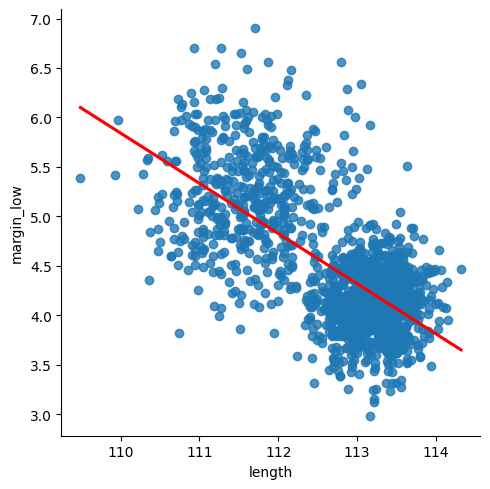

In [37]:
ax = sns.lmplot(x="length", y="margin_low", data=df_without_nan, ci=None,line_kws={'color':'r'})
ax.set(xlabel='length', ylabel='margin_low')
plt.show()

On peut également représenter les valeurs ajustées en fonction des valeurs observées :

/var/folders/69/d38cxkf54770xr1hp52j1_480000gn/T/ipykernel_43817/3816784378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_nan['margin_low_ajust_s'] = simp_reg.predict()


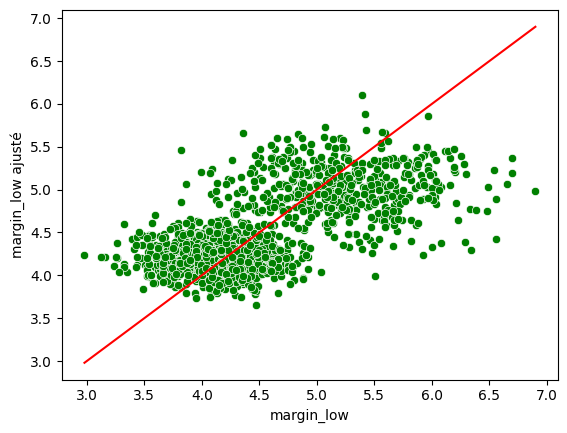

In [38]:
df_without_nan['margin_low_ajust_s'] = simp_reg.predict()
X_plot = [df_without_nan['margin_low'].min(), df_without_nan['margin_low'].max()]

ax = sns.scatterplot(x="margin_low", y="margin_low_ajust_s", data=df_without_nan,color='green')
ax.set(xlabel='margin_low', ylabel='margin_low ajusté')
plt.plot(X_plot, X_plot, color='r')
plt.show()

La droite qui s'affiche est la première bissectrice. Si le modèle était parfait,
les valeurs réelles et les valeurs ajustées seraient égales, donc sur un tel graphique, les points seraient alignés sur la droite d'équation $y=x$, soit la première bissectrice.

## Model residues <a name="Model"></a>

On peut obtenir les résidus du modèle à l'aide de cette commande :

In [39]:
df_without_nan['residu_s'] = simp_reg.resid

/var/folders/69/d38cxkf54770xr1hp52j1_480000gn/T/ipykernel_43817/889457715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_nan['residu_s'] = simp_reg.resid


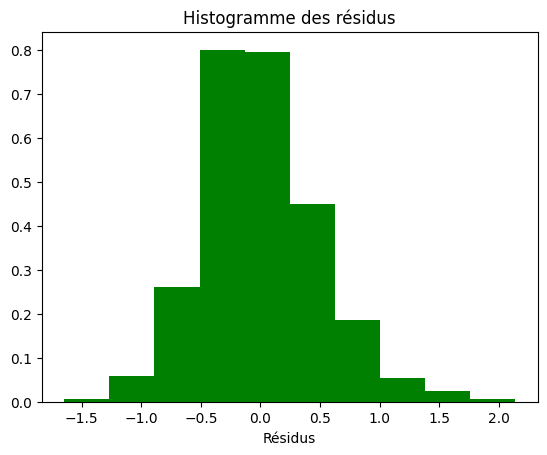

In [40]:
plt.hist(df_without_nan['residu_s'], density=True, color="Green")
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

L'allure de l'histogramme n'est pas centrée ni symétrique.

In [41]:
#Tester la normalité des résidus
shapiro(simp_reg.resid)

ShapiroResult(statistic=0.9824789762496948, pvalue=2.3925759377180222e-12)

Le test de Shapiro-Wilk donne une probabilité de dépassement de 0.1831, supérieure à 0.05. L'hypothèse de normalité est donc tolérée. Le test de Shapiro-Wilk donne une probabilité de dépassement de 0.0009, inférieure à 0.05. L'hypothèse de normalité est donc rejetée.

In [42]:
jarque_bera(simp_reg.resid)

SignificanceResult(statistic=133.01408667862088, pvalue=1.307248252771056e-29)

Probability est la probabilité que la valeur de Jarque-Bera dépasse la valeur critique. Si la probabilité est inférieure à 5%, on rejette l'hypothèse nulle de la distribution normale. Si la probabilité est supérieure à 5 , on accepte l'hypothèse nulle de la distribution normale.

# Multiple linear regression (MLR)  <a name="MLR"></a>

In [43]:
df_without_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajust_s,residu_s
0,1,171.81,104.86,104.95,4.52,2.89,112.83,4.407281,0.112719
1,1,171.46,103.36,103.66,3.77,2.99,113.09,4.275498,-0.505498
2,1,172.69,104.48,103.50,4.40,2.94,113.16,4.240018,0.159982
3,1,171.36,103.91,103.94,3.62,3.01,113.51,4.062618,-0.442618
4,1,171.73,104.28,103.46,4.04,3.48,112.54,4.554270,-0.514270


In [44]:
df_mlr=df_without_nan.drop(["margin_low_ajust_s","residu_s"], axis=1)
df_mlr.sample(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
189,1,172.18,104.02,103.54,4.17,3.49,113.64
726,1,171.79,103.74,103.48,4.60,2.80,113.35
468,1,171.83,103.97,104.00,3.72,3.13,113.83


## Model selection <a name="Model"></a>

In [45]:
multi_reg = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length',
                           data=df_mlr).fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          4.75e-299
Time:                        22:11:31   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

Retirer les variables non significatives
length: p-valeur de 0.87 et diagonal: p-valeur 0.72

In [46]:
multi_reg = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up',
                           data=df_mlr).fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          8.76e-302
Time:                        22:11:37   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3902      5.476      0.071   

Retirer height_right

In [47]:
multi_reg = smf.ols('margin_low~is_genuine+height_left+margin_up',
                           data=df_mlr).fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          3.63e-303
Time:                        22:11:42   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9104      4.035      0.721      

retirer height_left

In [48]:
multi_reg = smf.ols('margin_low~is_genuine+margin_up',
                           data=df_mlr).fit()
print(multi_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          1.24e-304
Time:                        22:11:50   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

Le meilleur modèle est "is_genuine+margin_up", les paramètres sont significatifs. Le coefficient de détermination, ou R2 a un meilleur score, environ 0.62 comme R2 ajusté. regression simple R2: 0.445.
la ligne de régression multiple se rapproche plus des données réelles.

## Test residual normality <a name="normality"></a>

In [49]:
#Tester la normalité des résidus
shapiro(multi_reg.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

Si la pvalue supérieure à 0,05, les données sont normales. S'il est inférieur à 0,05, les données s'écartent significativement d'une distribution normale.

In [50]:
#Tester la normalité des résidus
jarque_bera(multi_reg.resid)

SignificanceResult(statistic=39.105938892179935, pvalue=3.222947749222136e-09)

In [51]:
df_mlr['residu_s'] = multi_reg.resid

In [52]:
df_mlr.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,residu_s
0,1,171.81,104.86,104.95,4.52,2.89,112.83,0.369454
1,1,171.46,103.36,103.66,3.77,2.99,113.09,-0.359352
2,1,172.69,104.48,103.50,4.40,2.94,113.16,0.260051
3,1,171.36,103.91,103.94,3.62,3.01,113.51,-0.505114
4,1,171.73,104.28,103.46,4.04,3.48,112.54,0.014498


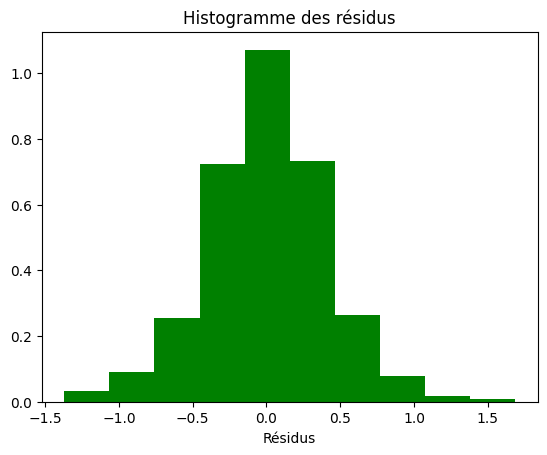

In [53]:
## Vérifier modèle: Les résidus doivent être Normaux**
## Représentons l'histogramme des résidus du modèle
plt.hist(df_mlr['residu_s'], density=True, color='Green')
plt.xlabel('Résidus')
plt.title('Histogramme des résidus')
plt.show()

L'allure de l'histogramme est centrée et peu symétrique.

{'Test Statistic': 166.92896597830813, 'p-value': 4.769905016347682e-35, 'F-Statistic': 46.94619855077708, 'F-Test p-value': 3.7024551237815678e-37}


Text(0.5, 1.0, 'Homoscedasticité')

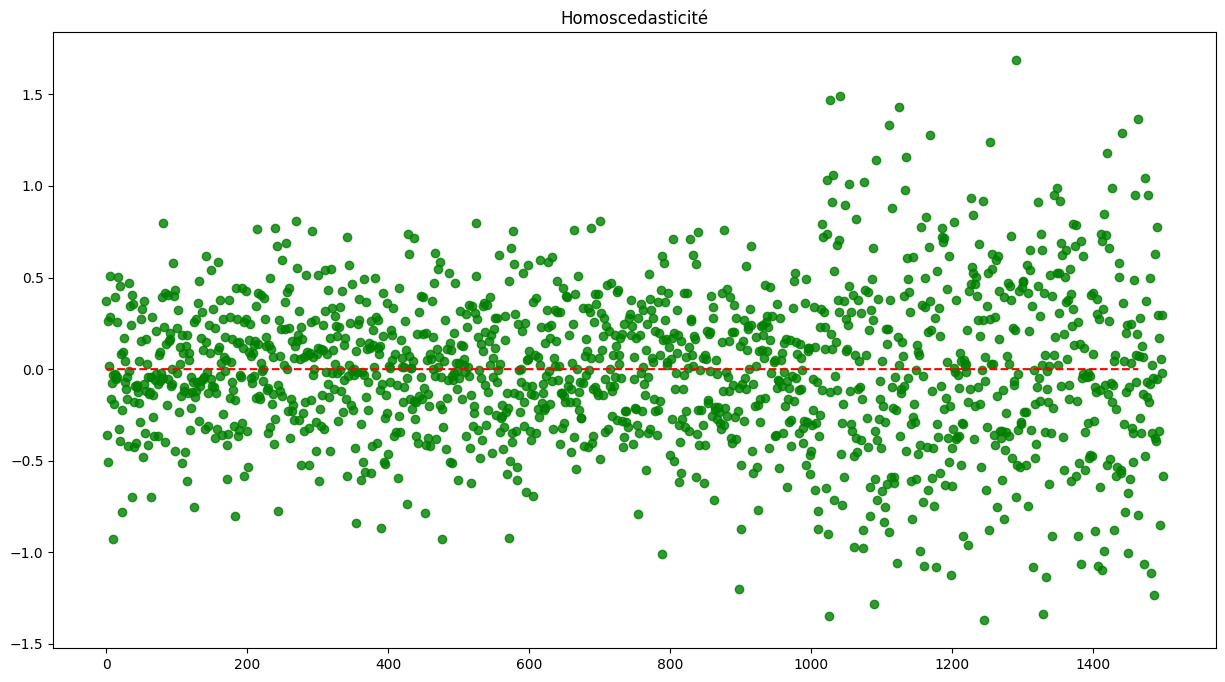

In [54]:
# white_test:
white_test = het_white(multi_reg.resid, multi_reg.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))


# Graphique:
plt.subplots(figsize=(15, 8))
plt.scatter(x=df_mlr.index, y=multi_reg.resid, alpha=0.8,color="g")
plt.plot(np.repeat(0, len(df_mlr.index)+2), color="r", linestyle='--')
plt.title("Homoscedasticité")

Le test de White est un test statistique qui établit si la variance des erreurs dans un modèle de régression est constante : c'est-à-dire pour l'homoscédasticité.La p-value est inférieure au seuil, on ne peut pas rejeter l'hypothèse nulle d'homoscedasticité.

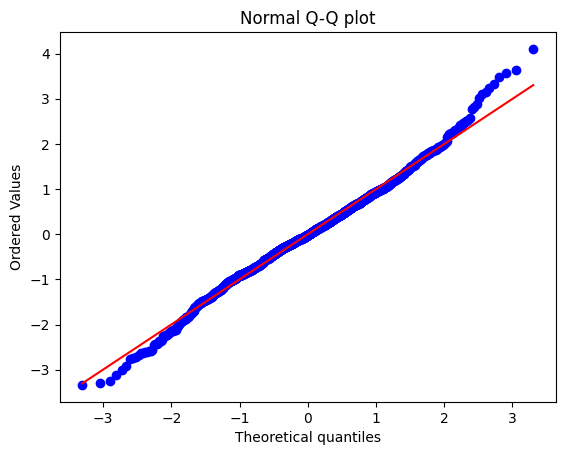

In [55]:
# Représentons le Diagramme Quantile Quantile
import scipy.stats as stats
z = (df_mlr['residu_s'] - df_mlr['residu_s'].mean())/df_mlr['residu_s'].std(ddof=1)
stats.probplot(z, dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

## Leverage calculation <a name="Leverage"></a>
Les effets de levier identifient les observations possédant des valeurs X inhabituelles ou aberrantes. Les observations ayant un effet de levier important possèdent des scores X éloignés de zéro et peuvent avoir une incidence significative sur les coefficients de régression. 

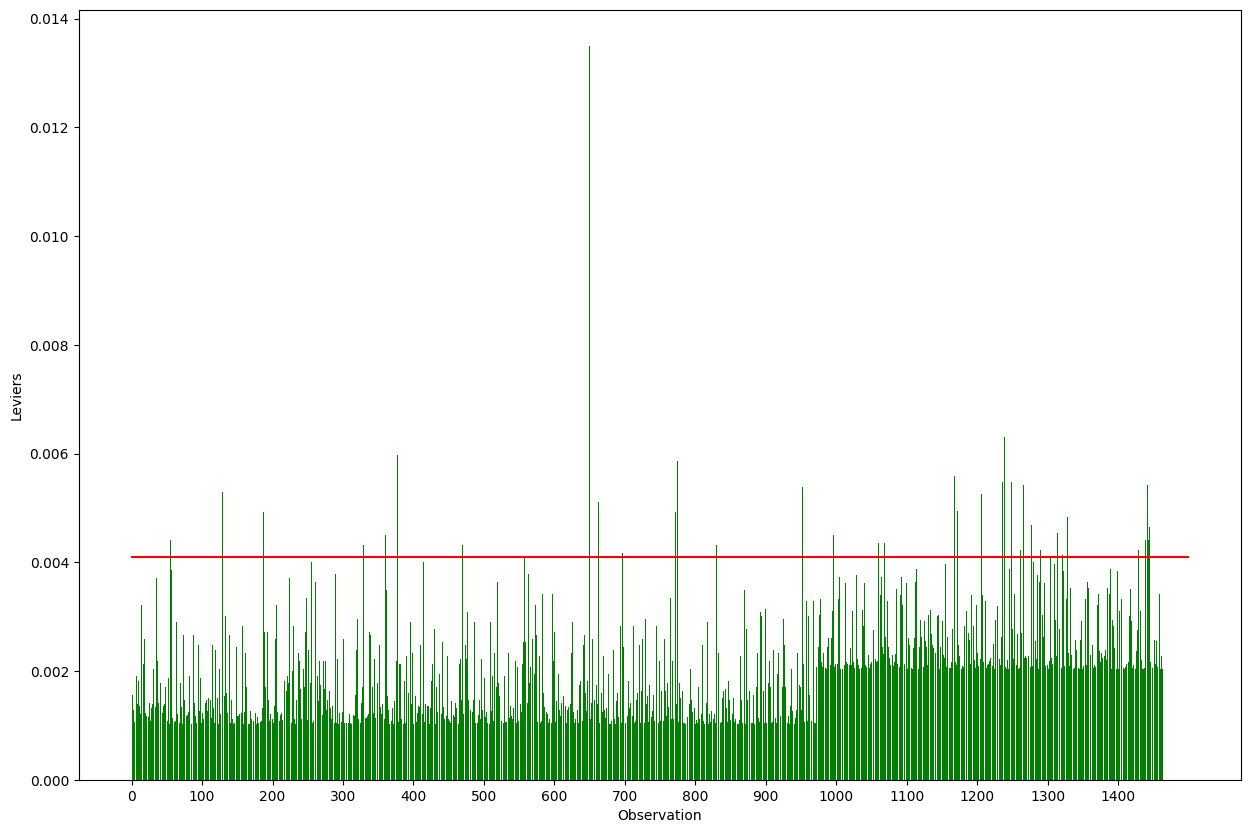

In [56]:
alpha = 0.05             #fixer alpha avec un seuile de 5%
n = df_mlr.shape[0]
p = 3                   # 3 variables

analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

analyses['levier'] = multi_reg.get_influence().hat_matrix_diag
seuil_levier = 2*p/n
plt.figure(figsize=(15,10))
plt.bar(analyses['obs'], analyses['levier'], color='g')
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

In [57]:
#Sélection des points pour lesquels le levier est supérieur au seuil
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
4,5,0.004748
48,49,0.007353
52,53,0.010647
54,55,0.004408
123,124,0.005865
...,...,...
1441,1442,0.005428
1442,1443,0.004406
1444,1445,0.004648
1446,1447,0.004796


67 observations peuvent être considérées comme atypiques

In [58]:
seuil_levier

0.004101161995898838

## Studentized residual <a name="Studentized"></a>
Le résidu de Student est calculé en prenant le résidu du modèle de régression et en le divisant par son erreur standard ajustée.

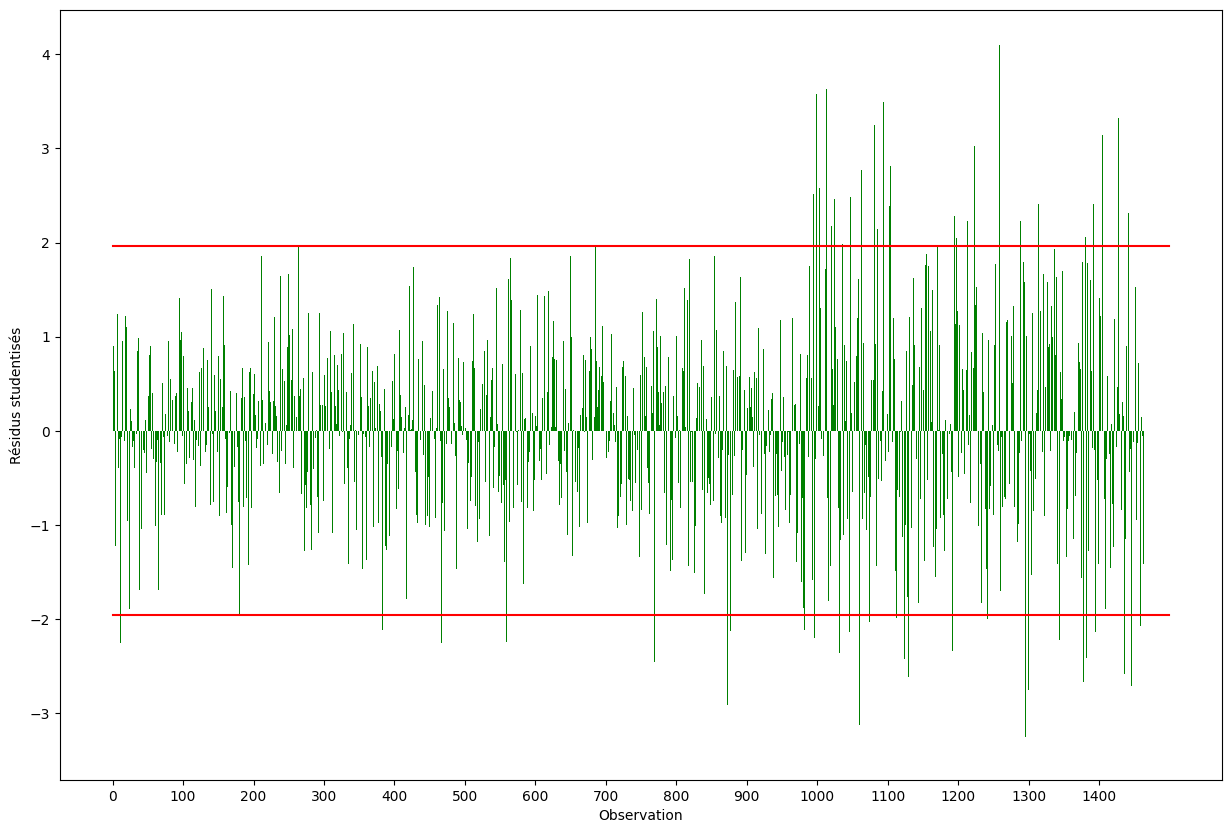

In [59]:
#Calculer les résidus studentisés
from scipy.stats import t, shapiro

analyses['rstudent'] = multi_reg.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)
plt.figure(figsize=(15,10))
plt.bar(analyses['obs'], analyses['rstudent'], color='g')
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [60]:
#Sélection des points pour lesquels le résidu studentisé est supérieur au seuil_rstudent
analyses.loc[(analyses['rstudent'] > seuil_rstudent )| (analyses['rstudent'] < -seuil_rstudent) ]

,obs,levier,rstudent
10,11,0.001360,-2.260280
263,264,0.001906,1.965931
346,347,0.003559,-2.047795
382,383,0.001109,-2.114700
466,467,0.002227,-2.257411
...,...,...,...
1436,1437,0.002500,2.536322
1441,1442,0.005428,2.317452
1445,1446,0.002168,-2.709317
1449,1450,0.002053,-2.999746


80 observations peuvent etre considérées comme atypiques

## Cook's distance <a name="Cook"></a>
La distance Cook représente la différence entre les coefficients B calculés et les valeurs qui auraient été obtenues si l'observation correspondante avait été exclue de l'analyse. Toutes les distances doivent être du même ordre de grandeur ; si ce n'est pas le cas, il y a de bonnes raisons de penser que la ou les observations respectives biaisent l'estimation des coefficients de régression.

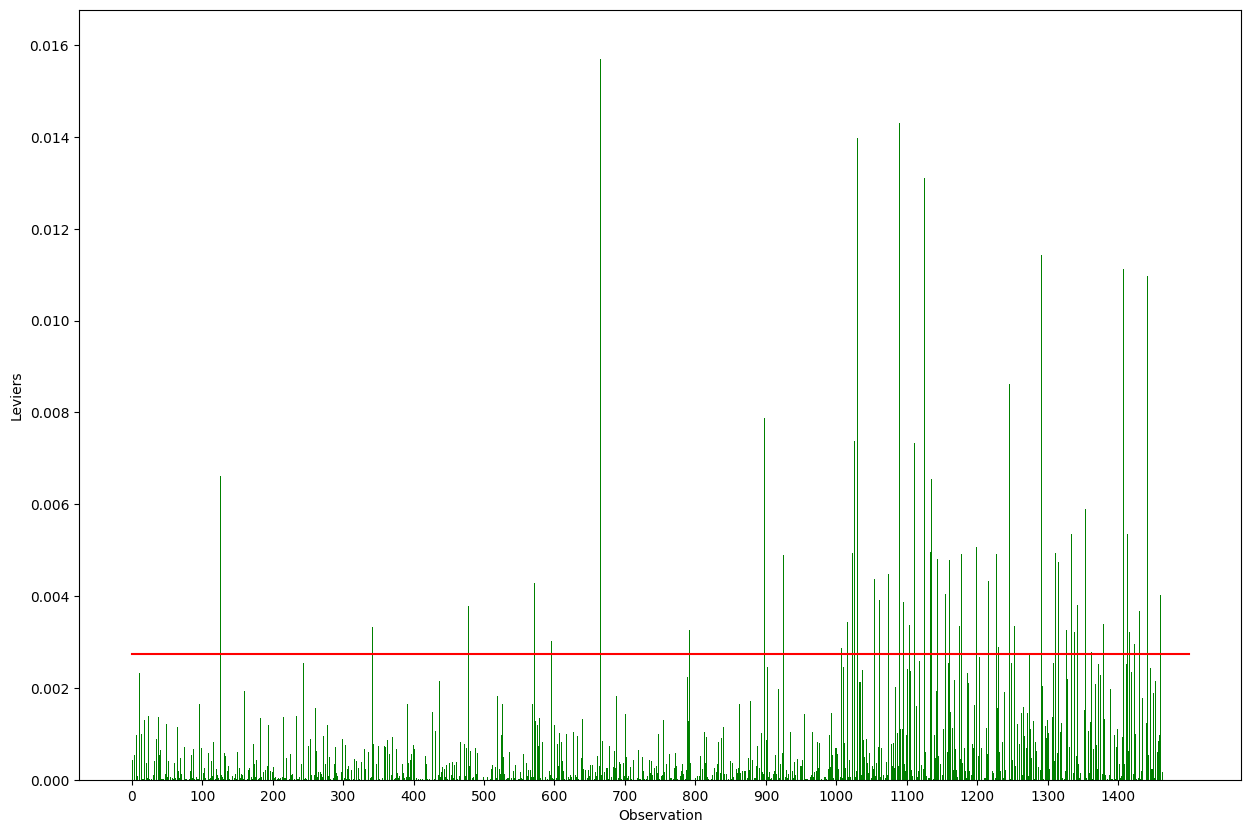

In [61]:
#Calcul de la distance de Cook
influence = multi_reg.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
#Le seuil de la distance de Cook est de n-p.
seuil_dcook = 4/(n-p)
#détecter les observations influentes
plt.figure(figsize=(15,10))
plt.bar(analyses['obs'], analyses['dcooks'], color='g')
plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [62]:
#Sélection des points pour lesquels La distance de Cook est supérieur au seuil de Cook
analyses.loc[analyses['dcooks'] > seuil_dcook, :]

,obs,levier,rstudent,dcooks
52,53,0.010647,-1.174185,0.004945
125,126,0.001204,0.667241,0.006626
239,240,0.001671,-0.215304,0.005198
341,342,0.001708,1.131974,0.003332
354,355,0.001204,-1.473461,0.004993
...,...,...,...,...
1426,1427,0.004228,-1.940064,0.005707
1429,1430,0.002053,0.675065,0.003686
1441,1442,0.005428,2.317452,0.010969
1450,1451,0.002703,-0.911463,0.004051


In [63]:
#vérifier l'éventuelle colinéarité approchée des variables
variables = multi_reg.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

Ici, tous les coefficients sont inférieurs à 10, donc, il n'y a pas de problème de colinéarité.

## Atypical observations <a name="Atypical"></a>

Nous allons selection un modèle en retirant tous les analyses de observations atypiques

In [64]:
atypical = analyses.loc[(analyses['dcooks'] > seuil_dcook)|   
             ((analyses['levier'] > seuil_levier) | 
              ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent))), :]

atypical

,obs,levier,rstudent,dcooks
4,5,0.004748,0.035332,0.000002
10,11,0.001360,-2.260280,0.002320
48,49,0.007353,-0.702636,0.001219
52,53,0.010647,-1.174185,0.004945
54,55,0.004408,-0.194290,0.000056
...,...,...,...,...
1449,1450,0.002053,-2.999746,0.001879
1450,1451,0.002703,-0.911463,0.004051
1453,1454,0.004136,1.890304,0.000325
1458,1459,0.003424,-2.073333,0.000984


In [65]:
atypical_list = atypical.index
df_atypical = df_mlr.loc[df_mlr.index.isin(atypical_list), :]
df_atypical

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,residu_s
4,1,171.73,104.28,103.46,4.04,3.48,112.54,0.014498
10,1,171.83,104.14,103.62,3.16,3.18,113.22,-0.929084
48,1,172.07,104.05,103.82,3.71,3.61,113.05,-0.287949
52,1,171.64,104.18,103.78,3.49,3.74,113.94,-0.480397
54,1,172.02,103.58,103.80,3.95,3.46,112.40,-0.079740
...,...,...,...,...,...,...,...,...
1449,0,171.66,104.10,104.15,4.53,3.40,111.83,-0.675657
1450,0,172.72,104.05,104.17,4.21,3.37,111.53,-1.002015
1453,0,171.55,104.20,104.49,5.42,3.54,109.93,0.244015
1458,0,171.65,104.00,104.53,5.69,3.41,111.09,0.486463


In [66]:
df_atypical['is_genuine'].value_counts()

is_genuine
0    159
1     59
Name: count, dtype: int64

In [67]:
df_atypical.loc[df_atypical['margin_low'].isnull(), 'is_genuine'].value_counts(normalize=True).round(2)

Series([], Name: proportion, dtype: float64)

159 faux billets contre 59 vrai billet, on va retirer les valeurs atypiquesafin d'ajuster le modèle.

In [68]:
df_model = df_mlr.loc[~df_mlr.index.isin(atypical_list), :]
df_model.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,residu_s
0,1,171.81,104.86,104.95,4.52,2.89,112.83,0.369454
1,1,171.46,103.36,103.66,3.77,2.99,113.09,-0.359352
2,1,172.69,104.48,103.50,4.40,2.94,113.16,0.260051
3,1,171.36,103.91,103.94,3.62,3.01,113.51,-0.505114
5,1,172.17,103.74,104.08,4.42,2.95,112.81,0.282170


In [70]:
df_model.shape

(1245, 8)

## Model validation <a name="validation"></a>

In [71]:
#Fonction de selection automatique du modele
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model

In [73]:
#Suppression des colonnes inutiles
data1=df_model.drop(['residu_s'], axis=1)
data1.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
5,1,172.17,103.74,104.08,4.42,2.95,112.81


In [74]:
columns = ['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']
reg_backward = backward_selected(data1[columns], 'margin_low')

_______________________________
margin_low ~ margin_up + height_left + is_genuine + length + height_right + diagonal + 1
remove height_right (p-value : 0.516 )

_______________________________
margin_low ~ margin_up + height_left + is_genuine + length + diagonal + 1
remove height_left (p-value : 0.484 )

_______________________________
margin_low ~ margin_up + is_genuine + length + diagonal + 1
remove diagonal (p-value : 0.268 )

_______________________________
margin_low ~ margin_up + is_genuine + length + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     832.6
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          1.49e-296
Time:                        22:26:37   Log-Likelihood:             

In [75]:
#Tester la normalité des résidus
shapiro(reg_backward.resid)

ShapiroResult(statistic=0.9987007975578308, pvalue=0.4994719922542572)

In [76]:
#Tester la normalité des résidus
jarque_bera(reg_backward.resid)

SignificanceResult(statistic=0.19394374572401918, pvalue=0.9075815334452946)

Ici la pvalue supérieure à 0,05, les données sont normales. nous pouvons valider ce modèle "margin_up + is_genuine + length" pour combler les valeurs null de margin_low

# Prediction missing values <a name="Prediction"></a>

In [77]:
df_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,NaN,3.25,112.79
99,1,171.93,104.07,104.18,NaN,3.14,113.08
151,1,172.07,103.80,104.38,NaN,3.02,112.93
197,1,171.45,103.66,103.80,NaN,3.62,113.27
241,1,171.83,104.14,104.06,NaN,3.02,112.36


In [78]:
X_nan = df_nan.drop(['margin_low'], axis=1)

In [79]:
y_nan = reg_backward.predict(X_nan)

In [80]:
X_nan['margin_low'] = y_nan
X_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,1,171.94,103.89,103.45,3.25,112.79,4.059770
99,1,171.93,104.07,104.18,3.14,113.08,4.096694
151,1,172.07,103.80,104.38,3.02,112.93,4.114783
197,1,171.45,103.66,103.80,3.62,113.27,4.004831
241,1,171.83,104.14,104.06,3.02,112.36,4.087658


In [81]:
X_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     int64  
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_up     37 non-null     float64
 5   length        37 non-null     float64
 6   margin_low    37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.3 KB


In [82]:
df_without_nan.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_ajust_s,residu_s
0,1,171.81,104.86,104.95,4.52,2.89,112.83,4.407281,0.112719
1,1,171.46,103.36,103.66,3.77,2.99,113.09,4.275498,-0.505498
2,1,172.69,104.48,103.50,4.40,2.94,113.16,4.240018,0.159982
3,1,171.36,103.91,103.94,3.62,3.01,113.51,4.062618,-0.442618
4,1,171.73,104.28,103.46,4.04,3.48,112.54,4.554270,-0.514270


In [83]:
df_without_nan1=df_without_nan.drop(['margin_low_ajust_s','residu_s'], axis=1)

In [84]:
df_without_nan1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   int64  
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 91.4 KB


## New dataframe without Nan value <a name="New"></a>

In [85]:
billets = pd.concat([df_without_nan1, X_nan])
billets.sample(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1321,0,172.29,104.72,104.86,5.71,3.16,112.15
1314,0,172.43,104.32,103.95,4.13,3.39,111.50
17,1,171.88,104.47,103.45,4.56,3.33,113.01


In [86]:
billets['is_genuine'].replace([0,1], [False, True], inplace=True)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [87]:
billets.shape

(1500, 7)

In [88]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482815,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659695,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


## Export CSV <a name="Export"></a>

In [89]:
path     = "data/cleaned/"
filename = "billets.csv"

In [90]:
df.to_csv(path+filename, index=False)

## New inspection without Nan <a name="new_inspection"></a>

In [91]:
billets.iloc[:,0].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

<Axes: ylabel='count'>

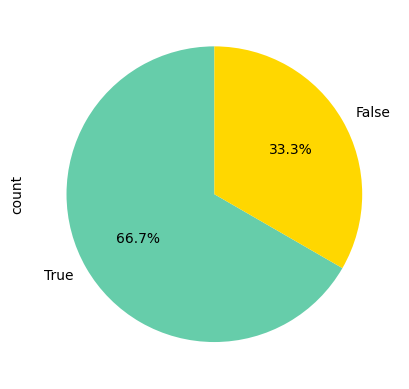

In [92]:
billets.iloc[:,0].value_counts().plot(kind="pie",startangle=90, autopct='%1.1f%%', colors = ['#66cdaa', '#ffd700'] )

In [93]:
billets.groupby('is_genuine').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.215857,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.116294,3.05213,113.20243


<Axes: xlabel='is_genuine', ylabel='margin_up'>

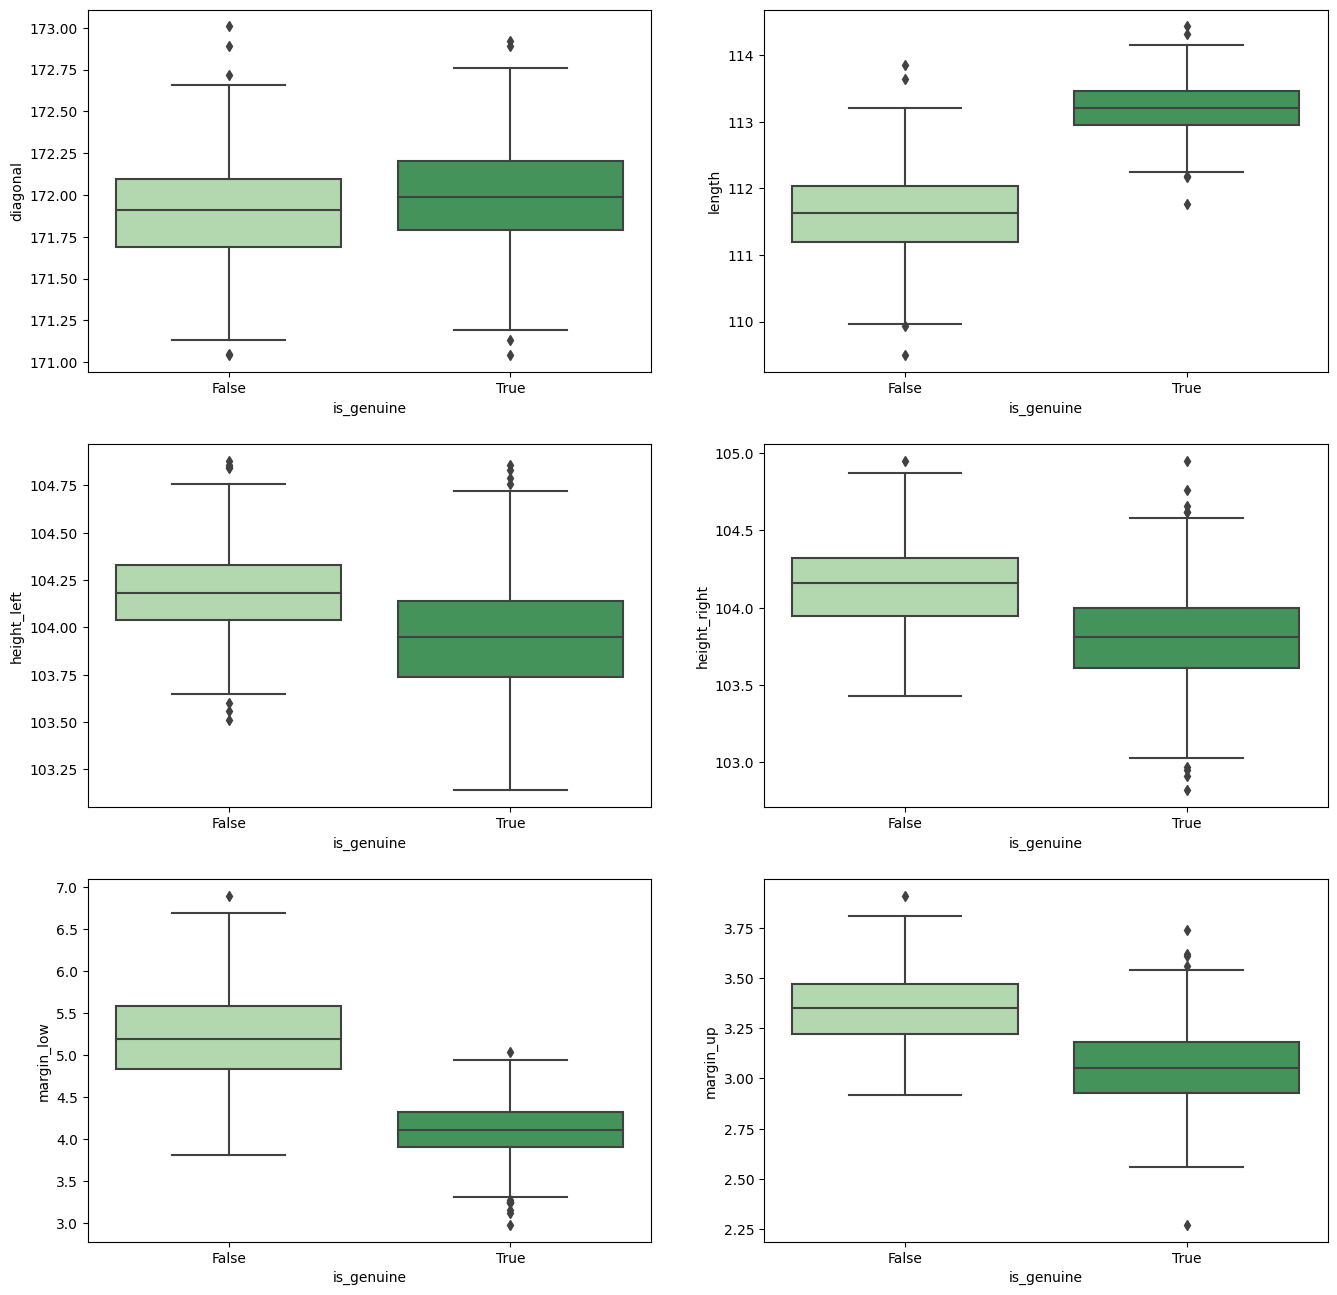

In [94]:
fig, axes= plt.subplots(3,2, figsize=(16,16))
sns.boxplot(y="diagonal", x="is_genuine", data=billets, ax=axes[0,0],palette="Greens")
sns.boxplot(y="length", x="is_genuine", data=billets, ax=axes[0,1],palette="Greens")
sns.boxplot(y="height_left", x="is_genuine", data=billets, ax=axes[1,0],palette="Greens")
sns.boxplot(y="height_right", x="is_genuine", data=billets, ax=axes[1,1],palette="Greens")
sns.boxplot(y="margin_low", x="is_genuine", data=billets, ax=axes[2,0],palette="Greens")
sns.boxplot(y="margin_up", x="is_genuine", data=billets, ax=axes[2,1],palette="Greens")

les faux billets sont plus important en marge (haut et bas) et en hauteur (gauche et droite), moins important en longueur. 

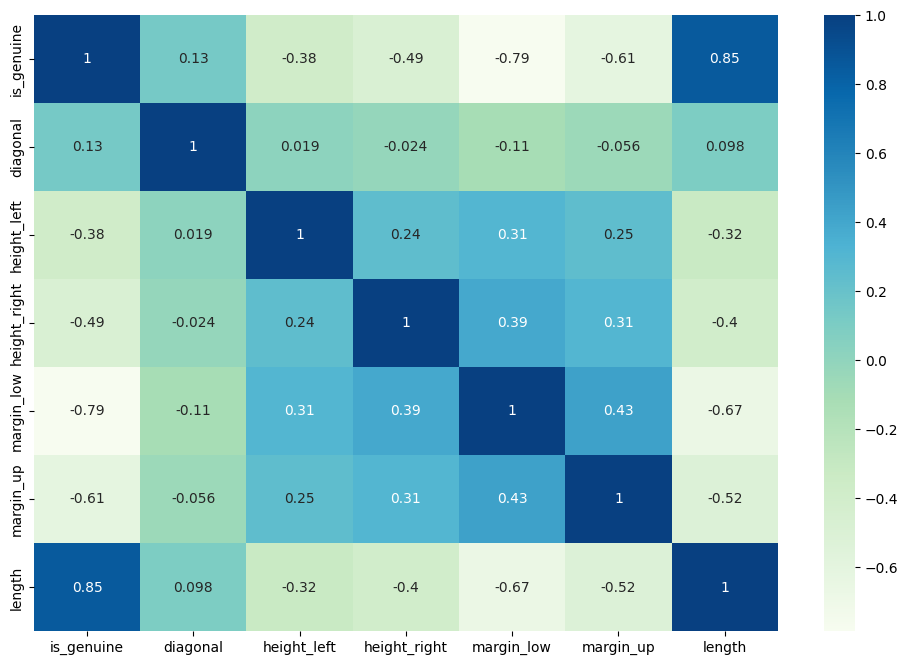

In [95]:
plt.figure(figsize = (12,8))
sns.heatmap(billets[['is_genuine','diagonal', 'height_left', 'height_right',
                'margin_low','margin_up', 'length']].corr(),annot=True, cmap="GnBu")
plt.show()

is_genuine a une forte correlation avec length, et une correlation négative avec margin_low

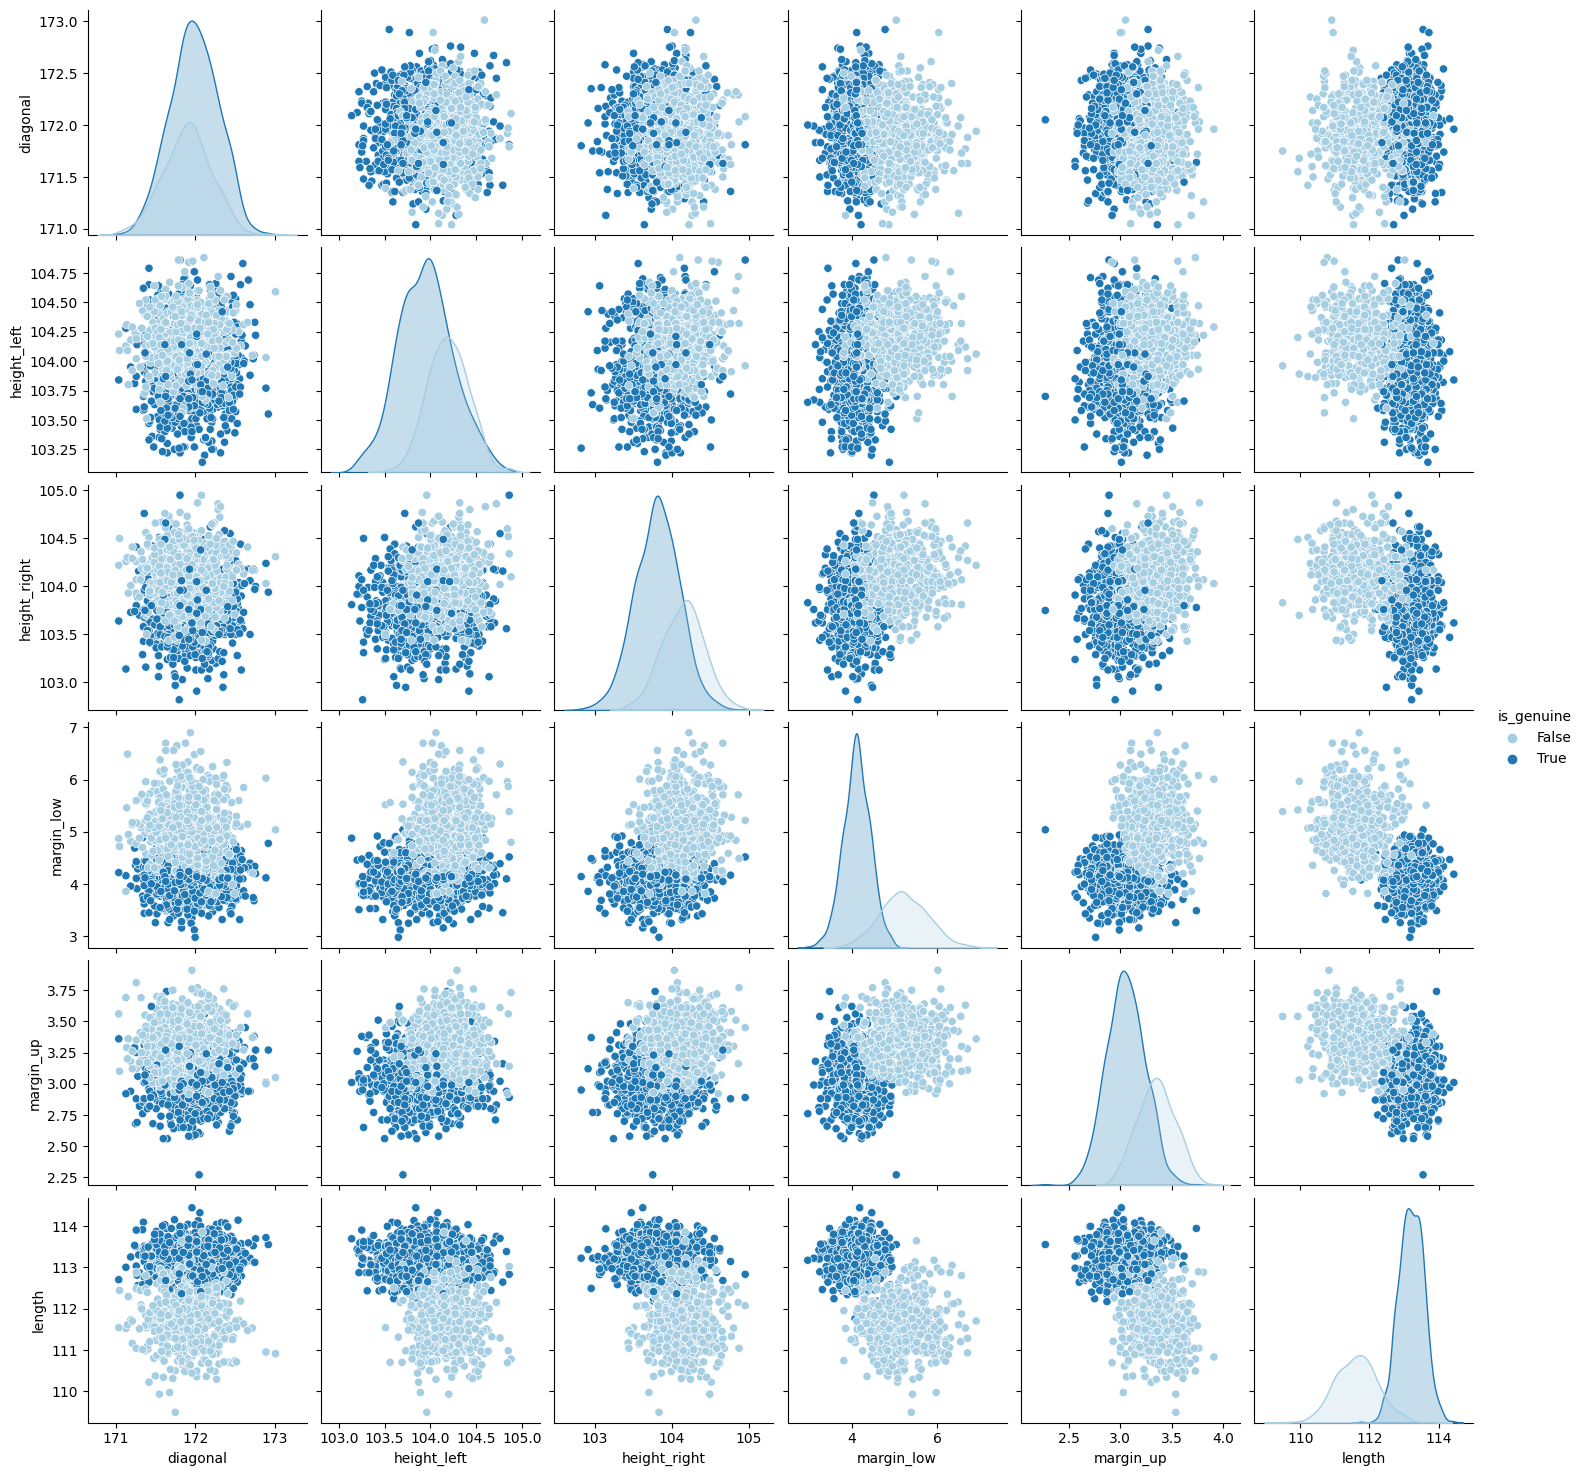

In [97]:
sns.pairplot(billets, hue="is_genuine", palette="Paired")

"lengh" et "margin_low" sont les dimenssions qui distinguent le plus les billets vrais et faux

# K-means <a name="K_means"></a>

## Data preparation <a name="scaler"></a>

In [98]:
X = billets.drop(columns= ['is_genuine'])
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [99]:
# Centrage et Réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.05638541, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08088264, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12557748, -0.91256208,
         0.55190114],
       ...,
       [-0.78153123,  1.43794766,  0.61346228,  0.90637547,  1.97866106,
        -2.71480344],
       [ 2.29949275,  1.00369058,  1.50434862,  1.00601893,  1.76289814,
        -1.38519737],
       [-0.19154792,  0.83666863,  1.135706  ,  1.10946802,  0.38201544,
        -1.36227312]])

In [100]:
df_centre = pd.DataFrame(X_scaled, columns=X.columns)
df_centre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1500 non-null   float64
 1   height_left   1500 non-null   float64
 2   height_right  1500 non-null   float64
 3   margin_low    1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
dtypes: float64(6)
memory usage: 70.4 KB


## PCA <a name="PCA"></a>
On réalise une analyse en composantes principales pour réduire les 6 variables et représenter nos billets dans un espace à 2 dimensions.

In [101]:
# Nombre de composantes souhaitées
n_comp = 6

# Calcul des composantes principales
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

In [102]:
# Proportion de variance expliquée
pca.explained_variance_ratio_

array([0.43195538, 0.16957487, 0.13019975, 0.1182453 , 0.0966735 ,
       0.05335121])

In [103]:
# Cumul de variance expliquée
pca.explained_variance_ratio_.cumsum()

array([0.43195538, 0.60153024, 0.73172999, 0.84997529, 0.94664879,
       1.        ])

## Scree plot <a name="Scree"></a>

In [104]:
# Définition de la fonction pour le graphique Éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie(%)")
    plt.title("Éboulis des valeurs propres")
    plt.show(block=False)

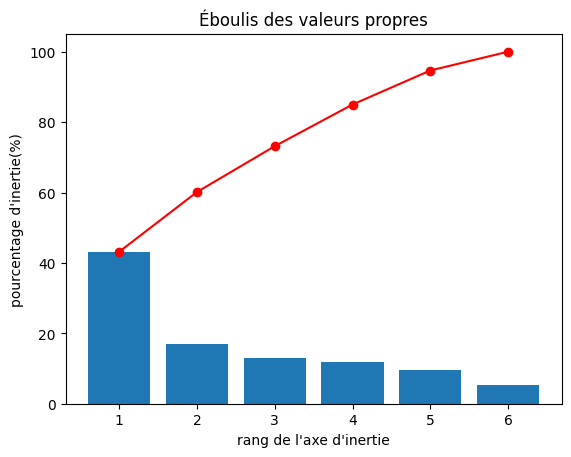

In [105]:
display_scree_plot(pca)
plt.show()

Les variables F1 et F2 qui représentent environ 60% de l'inertie totale.

## Correlation circle <a name="circle"></a>

In [106]:
# Définition de la fonction pour le graphique Cercle de corrélation
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 10))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

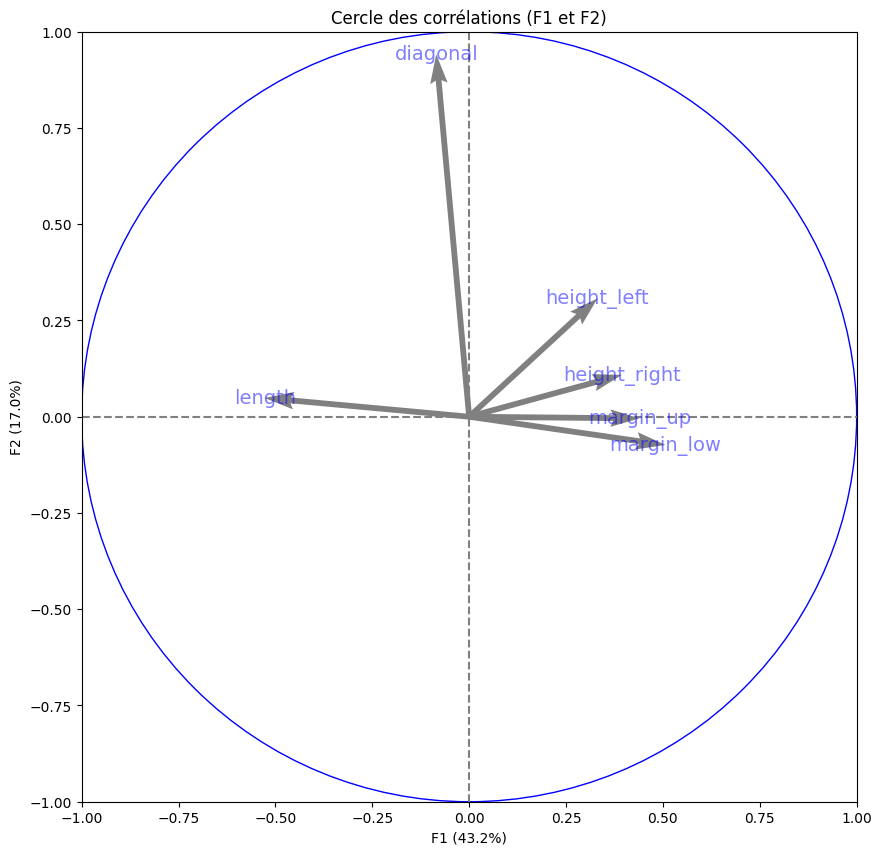

In [107]:
# Générer le Cercle des corrélations F1 et F2.
pcs = pca.components_ 
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(X.columns))

La composante F1 représente 43% de l'inertie totale. Les variables qui seraient corrélées (positivement) sont la hauteur et les marges :

height_left
height_right
margin_up
margin_low 

Les variables les plus corrélées négativement à F1 est "length"

La composante F2 représente 17% de l'inertie totale. Elle est corrélée à la longueur de la diagonale.

## Projection of individuals on the factorial plane <a name="Projection"></a>

In [108]:
# Définition de la fonction pour le graphique Projection des individus sur les plans factoriels
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(10, 10))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(
                        X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title(
                "Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

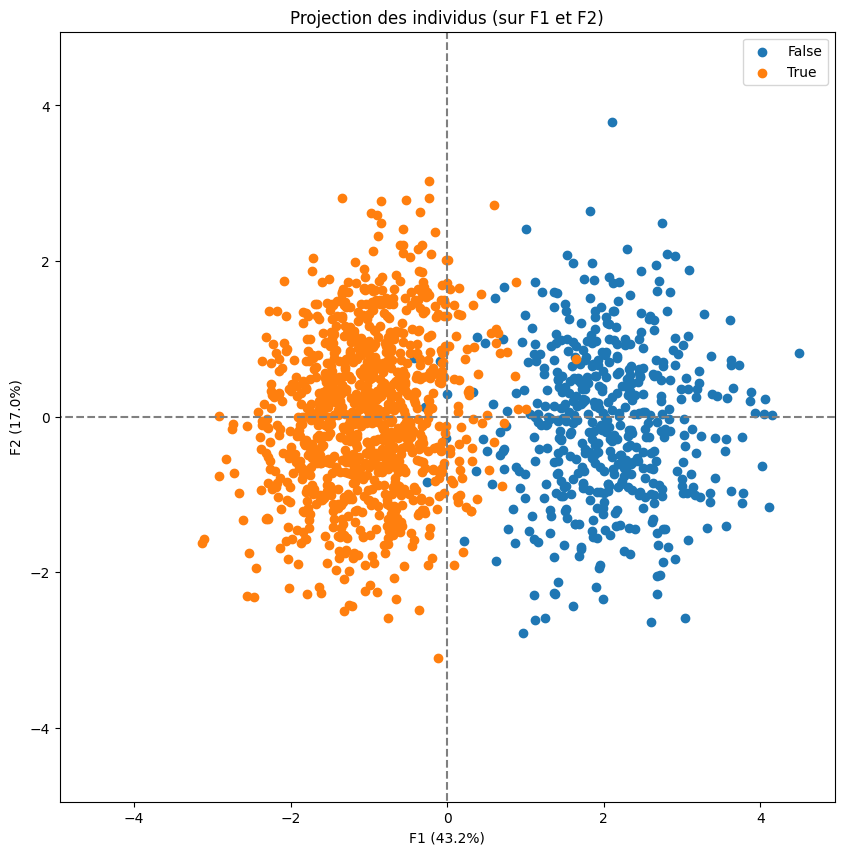

In [109]:
# Projection des individus sur F1 et F2 

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0, 1)], illustrative_var = billets.is_genuine,)

plt.show()

Les vrais billets se situent sur une partie gauche de la projection. L'authenticité des billets semble être corrélée par la composantes F1.

## Samples selection <a name="Samples"></a>

In [110]:
feature_cols = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = billets[feature_cols]
y = billets['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

80 % pour le training set 20 % pour le testing set.

In [111]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1200, 6)

(300, 6)

(1200,)

(300,)

## Implementation and prediction <a name="Implementation"></a>
La méthode des K-Means permet tout d'abord de déterminer 2 clusters parmis les individus correspondant aux vrais et faux billets. On détermine ensuite pour chacun des billets du jeu de donnée test, le groupe auquel il appartient. K-means (clustering non-supervisé)
L’algorithme du kmeans est un algorithme itératif qui minimise la somme des distances entre chaque individu et le centroïde du cluster ; c’est la variabilité intra cluster. Attribuer un cluster à chaque objet (ou sujet, ou point), de façon aléatoire.

In [112]:
# Nombre de clusters souhaités :  2 puisque l'on a 2 modalités pour la variable is_genuine.
n_clust = 2

# Clustering par K-means
modele_kmeans = cluster.KMeans(n_clusters=n_clust)
class_modele_kmeans = modele_kmeans.fit(X_train)

# Récupération des clusters attribués à chaque individu
k_means_clusters = class_modele_kmeans.labels_

df_K_means = pd.DataFrame(k_means_clusters)

y_pred_kmean = modele_kmeans.predict(X_test)

/Users/ai/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Centroid Calculation <a name="Centroid"></a>

In [113]:
# choix du nombre de composantes à calculer
n_comp = 2

# Calcul des composantes principales
pca2 = decomposition.PCA(n_components=n_comp)
pca2.fit(X_train)
X_scaled_projected_2 = pca2.transform(X_train)

In [114]:
centroids = class_modele_kmeans.cluster_centers_
centroids_projected = pca2.transform(centroids)

/Users/ai/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [115]:
centroids

array([[171.90010526, 104.19228947, 104.16273684,   5.24748071,
          3.34684211, 111.57542105],
       [171.97913415, 103.95459756, 103.81397561,   4.13484045,
          3.0569878 , 113.1852439 ]])

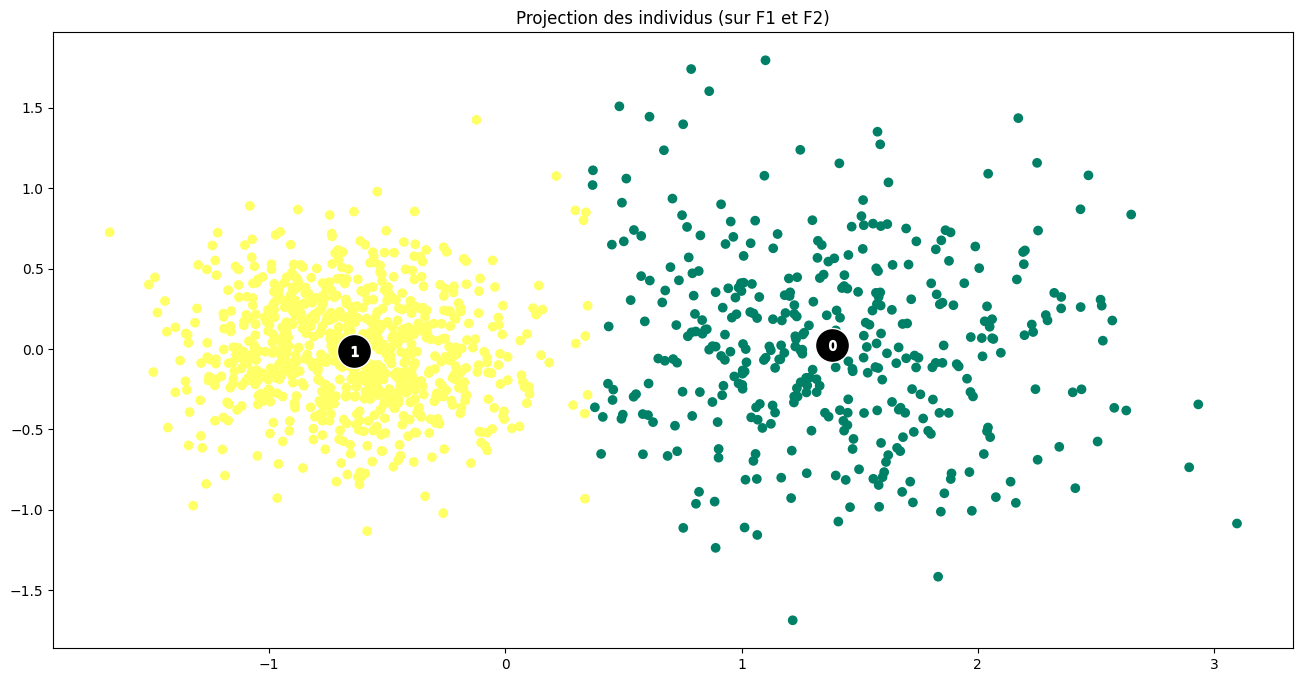

In [116]:
# Visualisations des centroides sur le 1er plan factoriel de l'ACP :
plt.figure(figsize=(16,8))
plt.scatter(X_scaled_projected_2[:, 0], X_scaled_projected_2[:, 1], c=k_means_clusters, cmap = 'summer')

plt.scatter(centroids_projected[:, 0], centroids_projected[:, 1], marker='o',
                c="black", alpha=1, s=600, edgecolor='w')
for i, c in enumerate(centroids_projected):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='w')
        
plt.title("Projection des individus (sur F1 et F2)")
plt.show(block=False)

## Confusion Matrix <a name="Matrix_K"></a>
Une matrice de confusion est utilisée pour évaluer la performance d'un modèle de classification. La matrice compare les valeurs cibles réelles avec celles prédites par le modèle d'apprentissage machine. Cela nous donne une vue d'ensemble des performances de notre modèle de classification et des types d'erreurs qu'il commet.

<Axes: xlabel='Predicted values', ylabel='Actual values'>

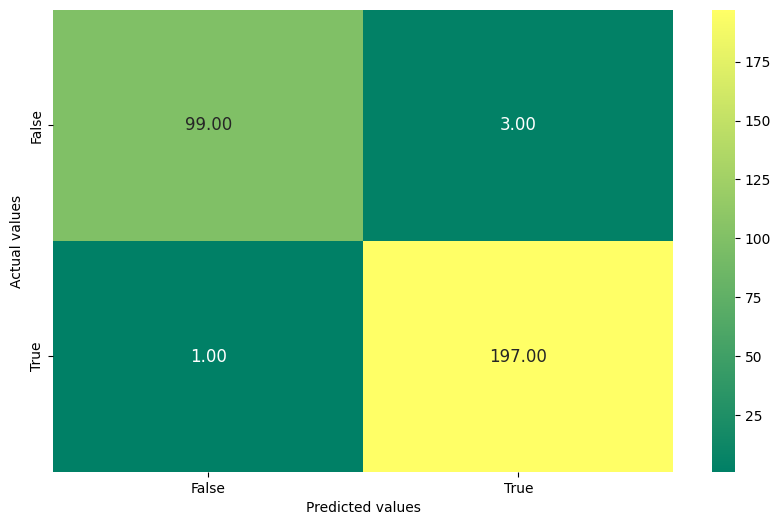

In [117]:
# Détermination des clusters True et False
valeurs_uniques, compte_des_valeurs_uniques = np.unique(y_pred_kmean, return_counts=True)

# On renomme les clusters
cluster_true = [
    index for index in valeurs_uniques if compte_des_valeurs_uniques[index] == max(compte_des_valeurs_uniques)]
cluster_false = [
    index for index in valeurs_uniques if compte_des_valeurs_uniques[index] != max(compte_des_valeurs_uniques)]

dict = {True: cluster_true, False: cluster_false}
y_test.replace(dict)

cnf_matrix = pd.crosstab(y_test, y_pred_kmean, rownames=['Actual values'], colnames=['Predicted values'])

cnf_matrix=cnf_matrix.rename(columns = {cluster_true[0]:'True'})
cnf_matrix=cnf_matrix.rename(columns = {cluster_false[0]:'False'})

plt.figure(figsize=(10,6))
sns.heatmap(cnf_matrix, cmap='summer',annot_kws = {'fontsize': 12},fmt = '.2f',annot=True)

In [118]:
y_pred_kmean_list = []

for x in y_pred_kmean:
    if x == cluster_true[0] :
        y_pred_kmean_list.append(True)
    else:
        y_pred_kmean_list.append(False)

print(metrics.classification_report(y_test, y_pred_kmean_list))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       102
        True       0.98      0.99      0.99       198

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



Precision: pourcentage de prédictions positives correctes par rapport au total des prédictions positives.true positive / (true positive + false positive),Ce nombre doit être le plus élevé possible.

Recall: nous indique la fraction de prédictions positives correctement identifiées. true positive / (true positive + false negative)

F1 Score: une moyenne harmonique pondérée de precision et recall. The closer to 1, the better the model.Plus il est proche de 1, meilleur est le modèle.F1 Score: 2 * (Precision * Recall) / (Precision + Recall)

Support est le nombre d'occurrences de chaque classe dans y_test

Accuracy: La précision mesure la précision de toutes les prédictions (positives et négatives).La précision doit être aussi élevée que possible. (true positive + true negative) / total predictions

Le modèle est quasiment parfait puisque tous les scores s'approchent de 1, on note toutefois des billets faux positifs et faux négatifs.

# Logistic regression (supervised classification) <a name="Logistic"></a>

L'objectif de la régression logistique est de modéliser, de classifier, une variable binaire prenant ses valeurs dans {0,1} en fonction de variables explicatives quantitatives (et potentiellement qualitatives).

## Data preparation <a name="data_lr"></a>

In [119]:
X1 = billets.drop(['is_genuine'], axis=1)
y1 = billets['is_genuine']

In [120]:
# Séparer training / testing set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.30, random_state=5)

In [121]:
X1_train.shape

(1050, 6)

In [122]:
X1_test.shape

(450, 6)

## Model building <a name="building"></a>

In [123]:
df_lr = pd.DataFrame(data = X1_train, index=X1_train.index, columns=X1_train.columns)
df_lr['is_genuine'] = y1_train
df_lr1 = df_lr.astype({'is_genuine': 'int64'})

In [124]:
df_lr1.sample(3)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
822,171.97,103.79,103.56,4.17,3.11,113.58,1
1114,172.10,104.10,104.20,5.16,3.16,111.85,0
144,171.80,104.31,103.78,3.79,3.12,112.78,1


In [125]:
def my_backward_selected_logistic(data, response):
    """Logistic regression model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels logistic regression model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response, ' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.logit(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value:', round(toRemove.values[0], 3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model!')
        print('')
    print(model.summary())

    return model

In [126]:
# On utilise la fonction my_backward_selected_logistic afin de trouvers les varibles descriptives les plus pertinentes
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
reg_backward_lr = my_backward_selected_logistic(df_lr1[columns], 'is_genuine')

_______________________________
is_genuine ~ margin_low + margin_up + height_left + length + height_right + diagonal + 1
Optimization terminated successfully.
         Current function value: 0.029102
         Iterations 13
remove height_left (p-value: 0.649 )

_______________________________
is_genuine ~ margin_low + margin_up + length + height_right + diagonal + 1
Optimization terminated successfully.
         Current function value: 0.029201
         Iterations 13
remove diagonal (p-value: 0.571 )

_______________________________
is_genuine ~ margin_low + margin_up + length + height_right + 1
Optimization terminated successfully.
         Current function value: 0.029355
         Iterations 12
is the final model!

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1050
Model:                          Logit   Df Residuals:                     1045
Method:                           ML

Pour ce modele, les variables descriptives significatives sont les suivantes :
* margin_up 
* margin_low 
* height_right  
* length

In [127]:
# On définit notre model
model_lr = LogisticRegression()

# On entraine notre model
model_lr = model_lr.fit(X1_train, y1_train)

# On enregistre les prédictions dans une variable y_pred
y_pred_lr = model_lr.predict(X1_test)

# On vérifie le score de notre model sur les données Test (F1 score)
score_f1_lr = f1_score(y1_test, y_pred_lr)
score_f1_lr = round(score_f1_lr*100,4)
print("Le score de notre model sur les données Test est de :", score_f1_lr,"%")

Le score de notre model sur les données Test est de : 99.3464 %


## ROC curve <a name="ROC"></a>

In [128]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y1_test, y_pred_lr)
roc_auc= auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)

0.99


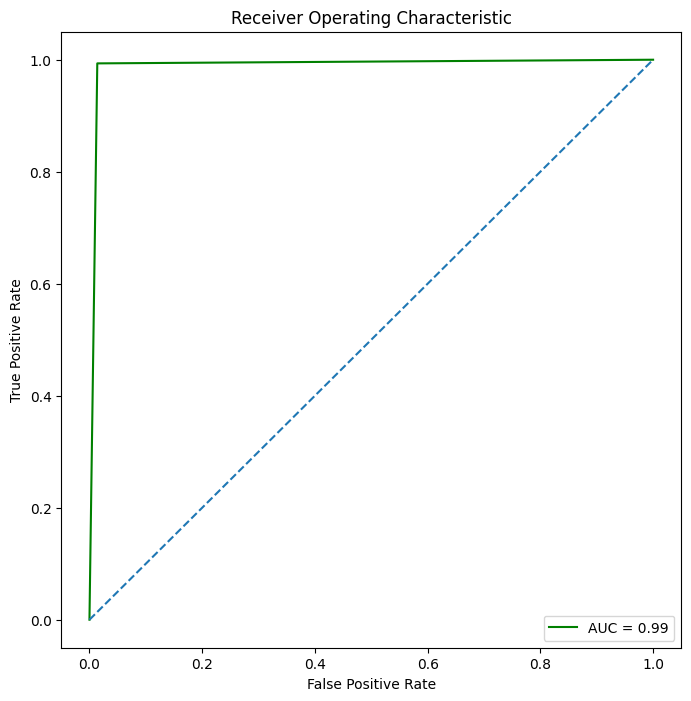

In [130]:
plt.figure (figsize = (8,8))
plt.title ('Receiver Operating Characteristic')
plt.plot (false_positive_rate, true_positive_rate, color= 'green', label = 'AUC = %0.2f' %roc_auc)
plt.legend (loc= 'lower right')
plt.plot([0,1], [0,1], linestyle = '--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AUC est la mesure de la capacité d'un classificateur binaire à faire la distinction entre les classes et est utilisé comme résumé de la courbe ROC. Plus l'AUC est élevée, meilleures sont les performances du modèle pour distinguer les classes positives et négatives. La valeur de l'AUC varie de 0 à 1. Un modèle dont les prédictions sont fausses à 100 % a une AUC de 0,0 ; celui dont les prédictions sont 100% correctes a une AUC de 1,0.ici AUC proche de 1.

## Confusion Matrix <a name="Matrix_lr"></a>

<Axes: xlabel='Predicted values', ylabel='Actual values'>

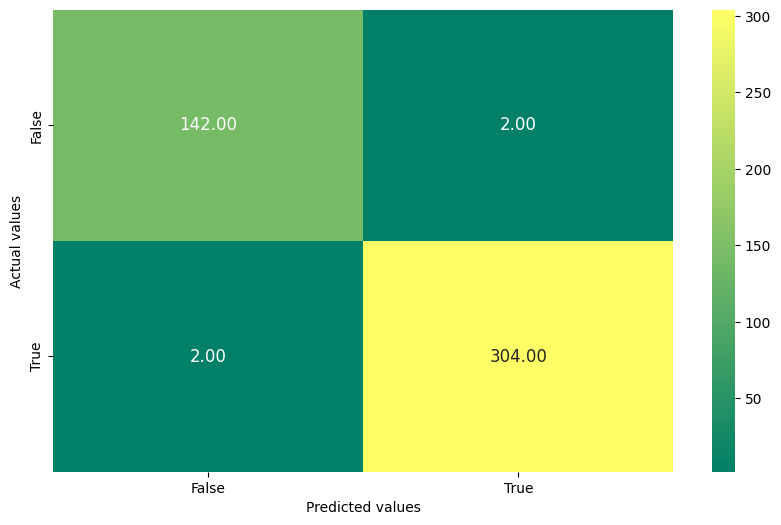

In [131]:
cnf_matrix2 = pd.crosstab(y1_test, y_pred_lr, rownames=['Actual values'], colnames=['Predicted values'])
plt.figure(figsize=(10,6))
sns.heatmap(cnf_matrix2, cmap='summer',annot_kws = {'fontsize': 12},fmt = '.2f', annot=True)

In [132]:
X1_test_lr_df = pd.DataFrame(data = X1_test, index=X1_test.index, columns=X1_test.columns)

# Prédiction des données de test
y_pred_lr_list = reg_backward_lr.predict(X1_test_lr_df)

In [133]:
y_pred_log_reg = list(map(round, y_pred_lr_list))

In [134]:
print(metrics.classification_report(y1_test, y_pred_log_reg))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       144
        True       1.00      1.00      1.00       306

    accuracy                           1.00       450
   macro avg       0.99      0.99      0.99       450
weighted avg       1.00      1.00      1.00       450



La méthode de régression logistique affiche un score de précision presque parfait et un faux positifs. 

## Comparison of the 2 models: K-means & Logistic Regression <a name="Comparison"></a>

In [408]:
print(f"""
Score régression logistique classique : {round(metrics.f1_score(y1_test, y_pred_log_reg), 4)}
Score méthode des k-means             : {round(metrics.f1_score(y_test, y_pred_kmean_list), 4)}
""")


Score régression logistique classique : 0.9967
Score méthode des k-means             : 0.9899



Le K_means ne prend pas en compte la variable is_genuine, il ne fait que regrouper les valeurs proches entre elles, mais cette methode n'est pas forcement pertinente pour predir si un billet est vrai/faux. 

Notre algorithme se devra d'être naturellement le plus performant possible, on décide de choisir la méthode de régression logistique qui offre un score plus élevé.

# Creation of prediction algorithm <a name="algorithm"></a>

In [135]:
def prediction (data, modele, seuil):
    data['proba_false'] = modele.predict(data)
    data['prediction'] = data['proba_false'] < seuil
    return data

## Testing the algorithm with billets_production <a name="billets_production"></a>

In [136]:
print(os.getcwd())

/Users/ai/Documents/Openclassrooms/Détectez des faux billets avec R ou Python


In [137]:
downloads_path = str(Path.home() / "Downloads/")

In [138]:
billets_production=pd.read_csv(downloads_path + '/billets_production.csv', sep =',')
billets_production.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [139]:
billets_production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      5 non-null      float64
 1   height_left   5 non-null      float64
 2   height_right  5 non-null      float64
 3   margin_low    5 non-null      float64
 4   margin_up     5 non-null      float64
 5   length        5 non-null      float64
 6   id            5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


In [140]:
del billets_production['id']

In [141]:
prediction(data=billets_production, modele=reg_backward_lr, seuil= 0.05 )

,diagonal,height_left,height_right,margin_low,margin_up,length,proba_false,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,0.000051,True
1,171.87,104.17,104.13,6.00,3.31,112.09,0.000004,True
2,172.00,104.58,104.29,4.99,3.39,111.57,0.000014,True
3,172.49,104.55,104.34,4.44,3.03,113.20,0.994526,False
4,171.65,103.63,103.56,3.77,3.16,113.33,0.999985,False
